# Predicting Tensile Strength of Composite Materials

## Introduction

<center>
    <img src = images/comp.jpeg width = 50%>
</center>

The Composite Materials dataset hosted on Kaggle provides a comprehensive collection of data intended to aid in the modeling and prediction of mechanical properties of composite materials. This dataset is particularly relevant for materials scientists and engineers focused on understanding how different constituent components—such as fiber type, matrix material, volume fraction, and manufacturing parameters—affect key mechanical performance indicators like tensile strength and Young’s modulus. It facilitates machine learning and regression-based studies, enabling researchers to explore the relationship between material composition and resultant properties. The dataset serves as a valuable resource for educational projects, industrial material design, and predictive modeling in composite mechanics.
    
The dataset can be used to train machine learning models that Young’s modulus based on constituent properties and processing conditions—helping accelerate material discovery and design. In industrial applications, engineers can utilize the dataset to optimize composite formulations for lightweight structures in aerospace, automotive, and civil engineering.

## CRISP-DM FRAMEWORK

<center>
    <img src = images/crisp.png width = 50%/>
</center>

To frame the task, throughout this project, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Here is a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).

### 1. Business Understanding

**Objective:** Predict one of important mechanical properties, Young’s modulus of composite materials based on their composition and processing parameters.

**Goals:**
- Develop a predictive model to assist material design.
- Identify which factors most strongly influence mechanical performance.
- Support material selection for lightweight, high-strength applications.

### 2. Data Understanding

#### Input:

- **Matrix-filler ratio:** The proportion of the polymer matrix to the filler material in the composite
- **Density, kg/m3:** The mass per unit volume of the composite material.
- **Modulus of elasticity, GPa:** Young’s modulus of the base material or resin, indicating its ability to resist elastic deformation.
- **Amount of hardener, m.%:** Percentage of hardening agent (often a curing agent in thermosets) relative to the total mass.
- **Content of epoxy groups, %:** The percentage of reactive epoxy functional groups in the resin formulation
- **Flash point, C_2:** The lowest temperature at which the resin emits vapors that can ignite in air.
- **Surface density, g/m2:** Mass of material (often fabric or prepreg) per unit surface area.
- **Tensile modulus of elasticity, GPa:** The modulus specifically measured under tensile (pulling) stress.
- **Resin consumption, g/m2:** The amount of resin required per unit area of reinforcement during composite fabrication.

#### Output:
- **Tensile strength, MPa:** Maximum stress the material can withstand under tension before failure.

#### Import Necessary Libraries

In [45]:
import numpy as np
import plotly.express as px
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

pd.set_option('display.max_rows', 10)
warnings.filterwarnings("ignore")

In [46]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

#### Import Data and Get General Information

In [47]:
raw_df = pd.read_excel('./data/X_bp.xlsx');
raw_df.head()

,Unnamed: 0,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2"
0,0,1.857143,2030.0,738.736842,30.00,22.267857,100.000000,210.0,70.0,3000.0,220.0
1,1,1.857143,2030.0,738.736842,50.00,23.750000,284.615385,210.0,70.0,3000.0,220.0
2,2,1.857143,2030.0,738.736842,49.90,33.000000,284.615385,210.0,70.0,3000.0,220.0
3,3,1.857143,2030.0,738.736842,129.00,21.250000,300.000000,210.0,70.0,3000.0,220.0
4,4,2.771331,2030.0,753.000000,111.86,22.267857,284.615385,210.0,70.0,3000.0,220.0


In [48]:
df = raw_df.rename(columns={
    'Соотношение матрица-наполнитель': 'Matrix-filler ratio',
    'Плотность, кг/м3': 'Density, kg/m³',
    'модуль упругости, ГПа': 'Modulus of elasticity, GPa',
    'Количество отвердителя, м.%': 'Amount of hardener, mass %',
    'Содержание эпоксидных групп,%_2': 'Content of epoxy groups, %',
    'Температура вспышки, С_2': 'Flash point, °C',
    'Поверхностная плотность, г/м2': 'Surface density, g/m²',
    'Модуль упругости при растяжении, ГПа': 'Tensile modulus of elasticity, GPa',
    'Прочность при растяжении, МПа': 'Tensile strength, MPa',
    'Потребление смолы, г/м2': 'Resin consumption, g/m²'
})
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,Matrix-filler ratio,"Density, kg/m³","Modulus of elasticity, GPa","Amount of hardener, mass %","Content of epoxy groups, %","Flash point, °C","Surface density, g/m²","Tensile modulus of elasticity, GPa","Tensile strength, MPa","Resin consumption, g/m²"
0,1.857143,2030.0,738.736842,30.00,22.267857,100.000000,210.0,70.0,3000.0,220.0
1,1.857143,2030.0,738.736842,50.00,23.750000,284.615385,210.0,70.0,3000.0,220.0
2,1.857143,2030.0,738.736842,49.90,33.000000,284.615385,210.0,70.0,3000.0,220.0
3,1.857143,2030.0,738.736842,129.00,21.250000,300.000000,210.0,70.0,3000.0,220.0
4,2.771331,2030.0,753.000000,111.86,22.267857,284.615385,210.0,70.0,3000.0,220.0


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023 entries, 0 to 1022
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Matrix-filler ratio                 1023 non-null   float64
 1   Density, kg/m³                      1023 non-null   float64
 2   Modulus of elasticity, GPa          1023 non-null   float64
 3   Amount of hardener, mass %          1023 non-null   float64
 4   Content of epoxy groups, %          1023 non-null   float64
 5   Flash point, °C                     1023 non-null   float64
 6   Surface density, g/m²               1023 non-null   float64
 7   Tensile modulus of elasticity, GPa  1023 non-null   float64
 8   Tensile strength, MPa               1023 non-null   float64
 9   Resin consumption, g/m²             1023 non-null   float64
dtypes: float64(10)
memory usage: 80.0 KB


**Comment**: 
- There are 9 columns, and 1023 entries. There is no missing value in dataset
- Mostly numeric columns (float64 or int64), making the dataset suitable for regression and correlation analysis.

In [50]:
df.describe()

,Matrix-filler ratio,"Density, kg/m³","Modulus of elasticity, GPa","Amount of hardener, mass %","Content of epoxy groups, %","Flash point, °C","Surface density, g/m²","Tensile modulus of elasticity, GPa","Tensile strength, MPa","Resin consumption, g/m²"
count,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000
mean,2.930366,1975.734888,739.923233,110.570769,22.244390,285.882151,482.731833,73.328571,2466.922843,218.423144
std,0.913222,73.729231,330.231581,28.295911,2.406301,40.943260,281.314690,3.118983,485.628006,59.735931
min,0.389403,1731.764635,2.436909,17.740275,14.254985,100.000000,0.603740,64.054061,1036.856605,33.803026
25%,2.317887,1924.155467,500.047452,92.443497,20.608034,259.066528,266.816645,71.245018,2135.850448,179.627520
50%,2.906878,1977.621657,739.664328,110.564840,22.230744,285.896812,451.864365,73.268805,2459.524526,219.198882
75%,3.552660,2021.374375,961.812526,129.730366,23.961934,313.002106,693.225017,75.356612,2767.193119,257.481724
max,5.591742,2207.773481,1911.536477,198.953207,33.000000,413.273418,1399.542362,82.682051,3848.436732,414.590628


#### SUMMARY

**Matrix-filler ratio**
- Mean: 2.93, indicating that on average, the matrix is almost three times more prevalent than the filler. Range: 0.39 to 5.59, showing diverse compositions across samples.
- Insight: A higher matrix ratio may lead to lower stiffness but increased toughness.

**Density (kg/m³)**:
- Mean: 1975.73 kg/m³
- Std Dev: 73.73 kg/m³ — moderate variability.
- Range: 1731.76 to 2207.77 kg/m³
- Insight: The dataset focuses on medium- to high-density composite materials, suitable for structural applications.

**Modulus of Elasticity (GPa)**
- Mean: 739.92 GPa — quite high, which may reflect the stiffness of constituent materials.
- Range: 2.44 to 1911.54 GPa — wide variation depending on composite formulation.

**Amount of Hardener (mass %)**
- Mean: 110.57%. Range: 17.74% to 198.95%
- Insight: Some formulations use significantly higher hardener content, which may influence curing rate and crosslink density.

**Content of Epoxy Groups (%)**
- Mean: ~22.24%
- Insight: This controls the cross-linking potential and impacts mechanical and thermal performance.

**Flash Point (°C)**
- Mean: 285.88°C
- Range: 100°C to 364.61°C
- Insight: Higher flash points imply safer processing and higher thermal stability.

**Surface Density (g/m²)**
- Mean: 482.73 g/m². Std Dev: 281.31 — high variation.
- Insight: Indicates varied prepreg or fiber areal weights, which affect final part thickness and performance.

**Tensile Modulus of Elasticity (GPa)**
- Mean: 73.33 GPa. Range: 64.05 to 81.44 GPa
- Insight: Moderate variation suggests consistent tensile stiffness across samples.

**Tensile Strength (MPa)**
- Mean: 2466.92 MPa
- Range: 1036.86 to 3630.35 MPa
- Insight: High strength levels, consistent with advanced structural composites.

**Resin Consumption (g/m²)**
- Mean: 218.42 g/m²
- Range: 33.80 to 382.49 g/m²
- Insight: Wide variability may be related to fiber architecture and manufacturing process.

#### Data Analysis

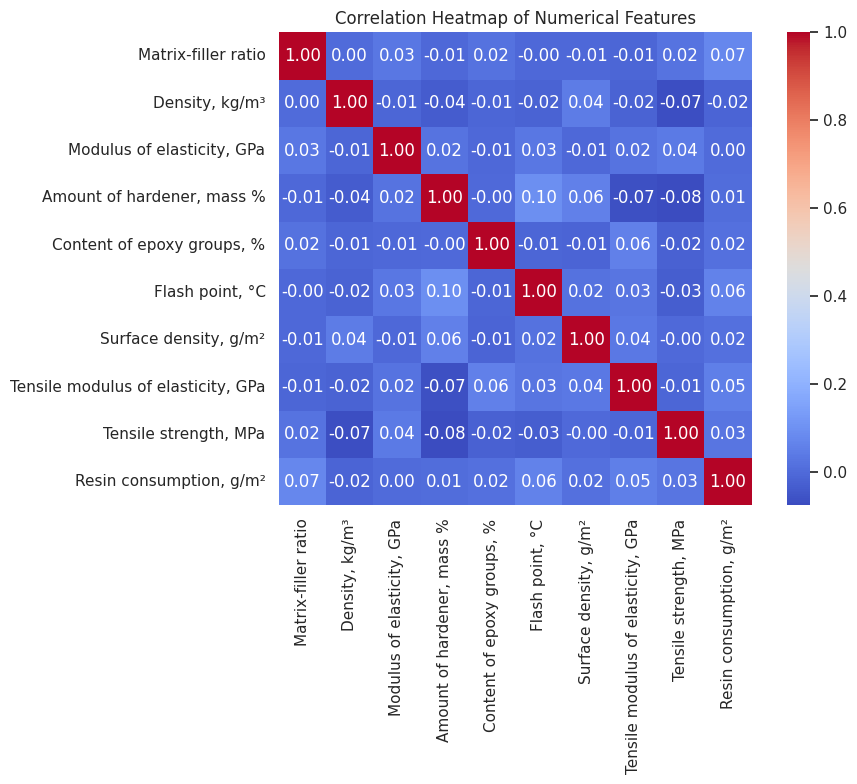

In [51]:
# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap of Numerical Features")
plt.tight_layout()
plt.show()

In [52]:
# Calculate correlation of all features with Tensile strength
corr_with_target = df.corr(numeric_only=True)['Tensile strength, MPa'].drop('Tensile strength, MPa')

# Sort by absolute correlation value for better insight
corr_sorted = corr_with_target.abs().sort_values(ascending=False).to_frame(name='Correlation with Tensile Strength')
corr_sorted['Signed Correlation'] = corr_with_target[corr_sorted.index]
corr_sorted

,Correlation with Tensile Strength,Signed Correlation
"Amount of hardener, mass %",0.075375,-0.075375
"Density, kg/m³",0.069981,-0.069981
"Modulus of elasticity, GPa",0.041868,0.041868
"Flash point, °C",0.031763,-0.031763
"Resin consumption, g/m²",0.028602,0.028602
Matrix-filler ratio,0.024148,0.024148
"Content of epoxy groups, %",0.023899,-0.023899
"Tensile modulus of elasticity, GPa",0.009009,-0.009009
"Surface density, g/m²",0.003210,-0.003210


**Comment**: The correlation analysis reveals that tensile strength has very weak linear relationships with all other numerical input features in the dataset.

**Positive Correlations:**
- Modulus of Elasticity (GPa): +0.042. Suggests a very slight trend that stiffer materials may have slightly higher tensile strength, though this is statistically negligible.

**Negative Correlations:**
- Amount of Hardener (mass %): –0.075
- Density (kg/m³): –0.070
- Flash Point (°C): –0.032
- These show slight negative trends, implying that as these values increase, tensile strength may decrease marginally. However, these values are far too low to suggest a meaningful or actionable relationship.

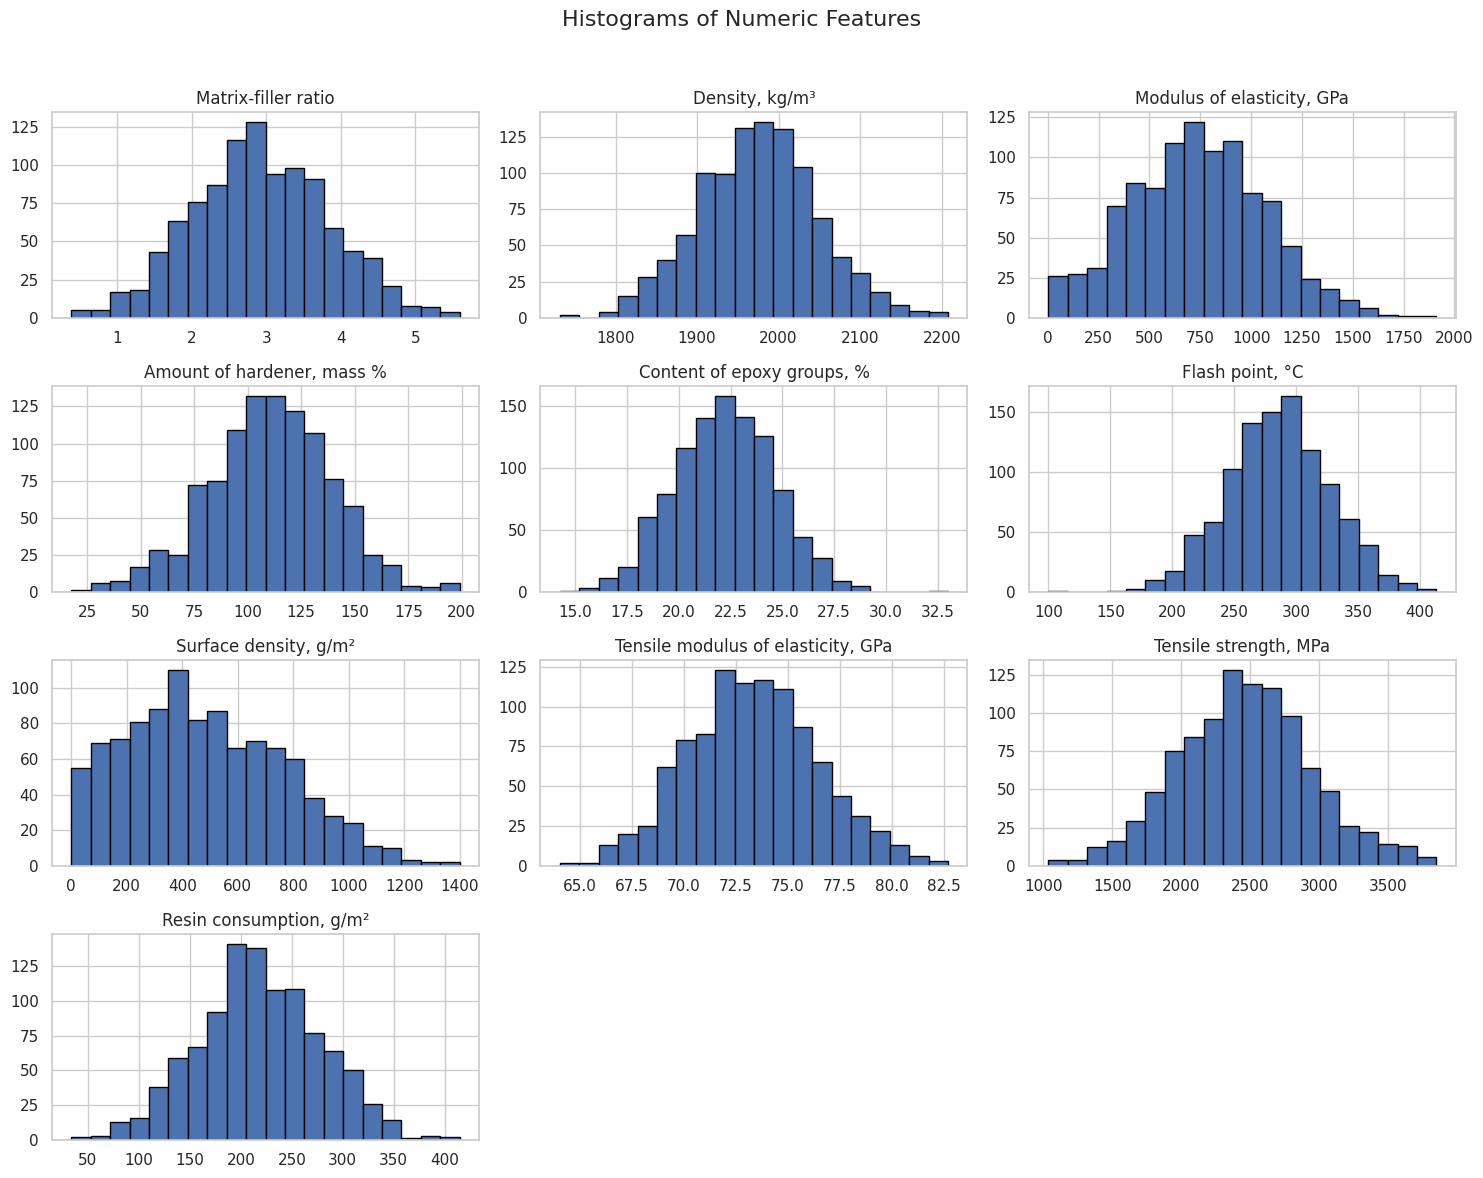

In [53]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Histogram for each numeric feature
df.hist(figsize=(15, 12), bins=20, edgecolor='black')
plt.suptitle("Histograms of Numeric Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

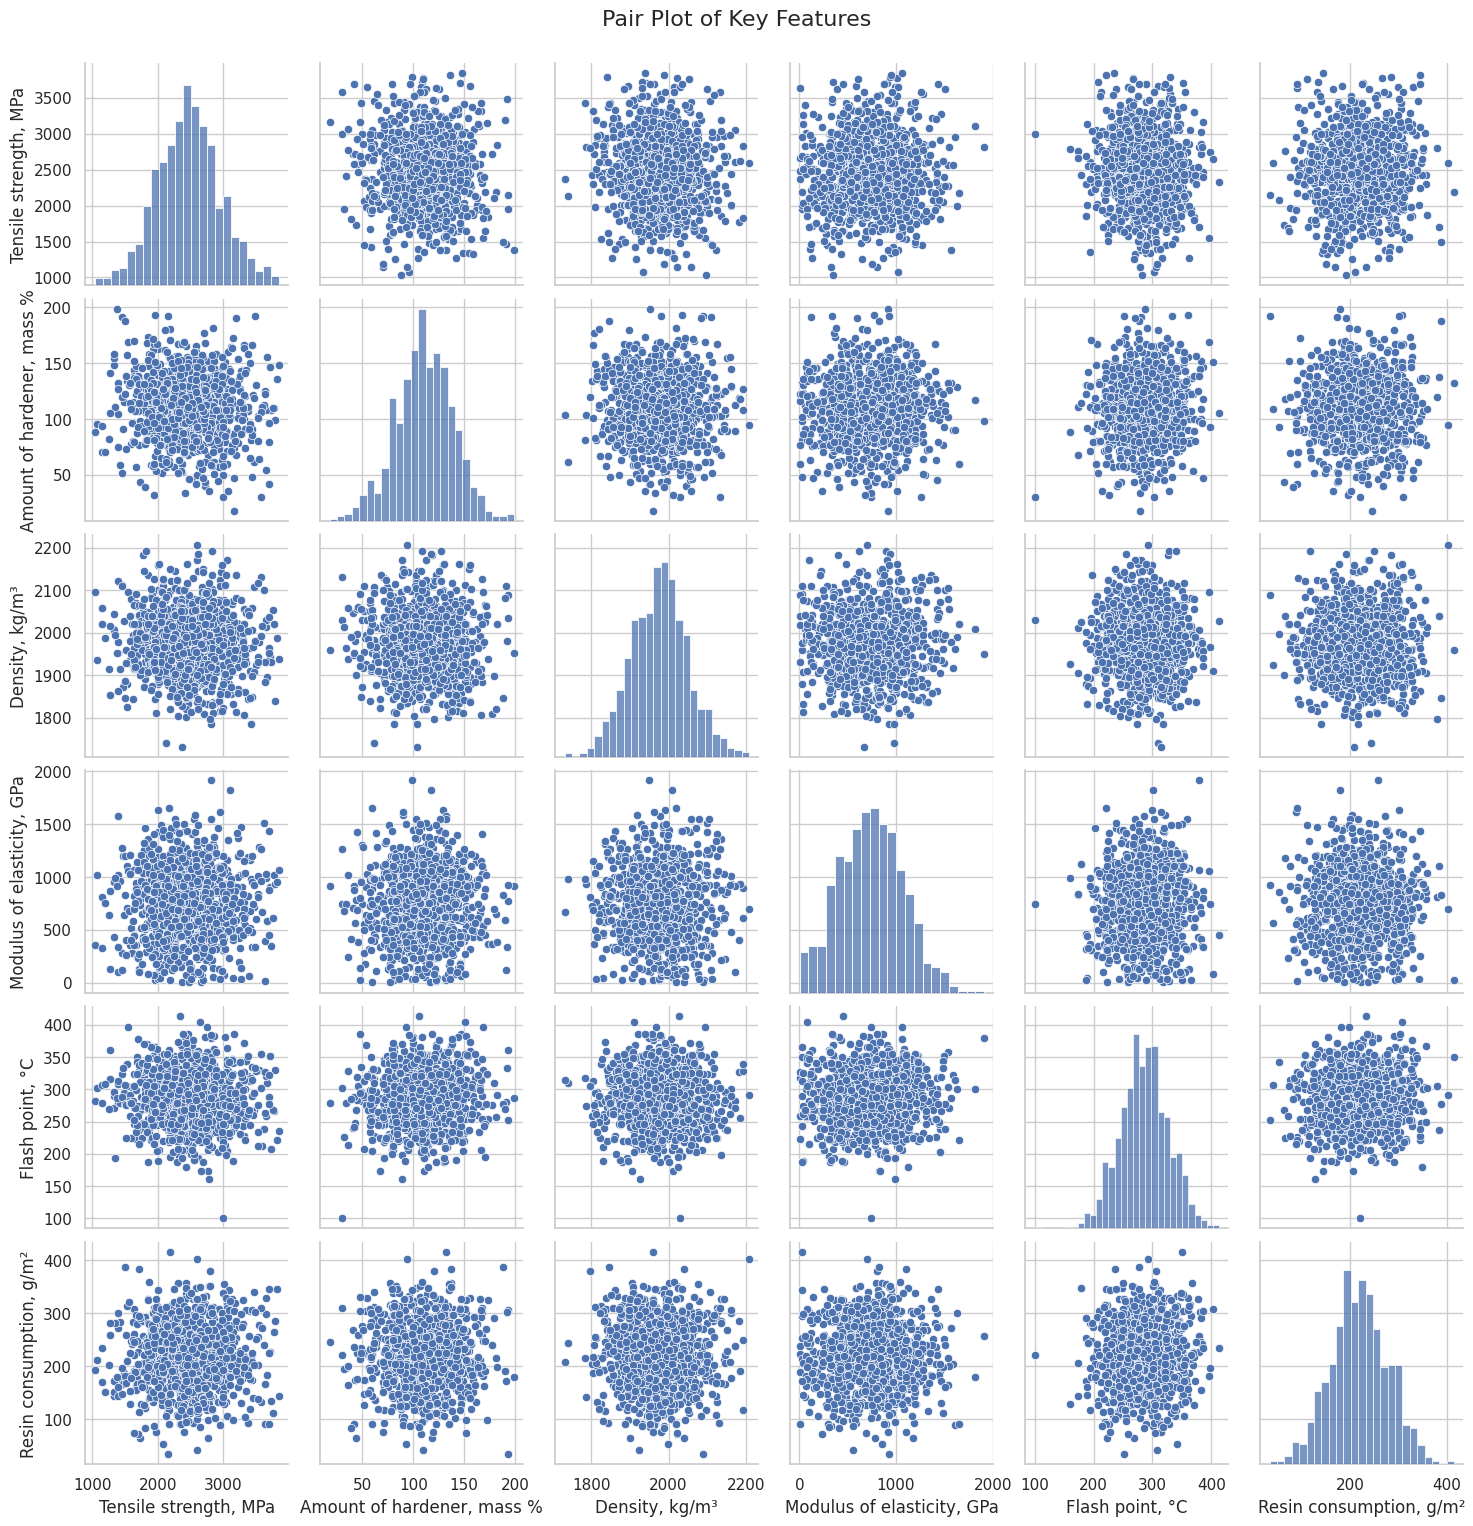

In [54]:
# 2. Pair plot (subset to avoid overcrowding)
sns.pairplot(df[['Tensile strength, MPa','Amount of hardener, mass %','Density, kg/m³',
                'Modulus of elasticity, GPa', 'Flash point, °C', 'Resin consumption, g/m²']])
plt.suptitle("Pair Plot of Key Features", fontsize=16, y=1.02)
plt.show()

**Histograms** showing the distribution of each numeric feature. Most features show moderately normal or skewed distributions, with Tensile Strength and Resin Consumption having wide spreads.

#### Feature Engineering

- To find meaningful ratios among the factors influencing tensile strength in composites, we focus on combining features that relate to reinforcement content, matrix effectiveness, and mechanical performance. Ratios can help normalize effects or reveal proportional trends.

1. **Matrix Efficiency Ratio:** Tensile strength / Matrix-filler ratio
- Interpretation: Strength achieved per unit matrix content.
- A higher value suggests the matrix is effectively transferring load to the filler.

2. **Specific Tensile Strength:** Tensile strength / Density
- Interpretation: Measures how strong the composite is per unit weight.
- Used widely in aerospace and automotive industries for lightweight design.

3. **Modulus-to-Strength Ratio:** Modulus of elasticity / Tensile strength
- Interpretation: Indicates brittleness.
- A higher value implies stiffer but potentially more brittle material.

4. **Fiber Efficiency Ratio:** Tensile strength / Resin consumption
- Interpretation: Evaluates how efficiently the composite converts resin mass into tensile strength.
- Useful for optimizing resin usage vs strength.

5. **Crosslinking Efficiency:** Tensile strength / Amount of hardener
- Interpretation: Higher values could indicate more efficient curing and stronger fiber-matrix interface.

In [55]:
df["Matrix Efficiency Ratio"] = df["Tensile strength, MPa"] / df['Matrix-filler ratio']
df["Specific Tensile Strength"] = df["Tensile strength, MPa"] / df["Density, kg/m³"]
df["Modulus-to-Strength"] = df['Tensile modulus of elasticity, GPa'] / df['Tensile strength, MPa']
df["Fiber Efficiency Ratio"] = df["Tensile strength, MPa"] / df['Resin consumption, g/m²']
df["Crosslinking Efficiency"] = df["Tensile strength, MPa"] / df['Amount of hardener, mass %']
df["Stiffness-to-Fiber-Loading"] = df['Tensile modulus of elasticity, GPa'] / df['Matrix-filler ratio']

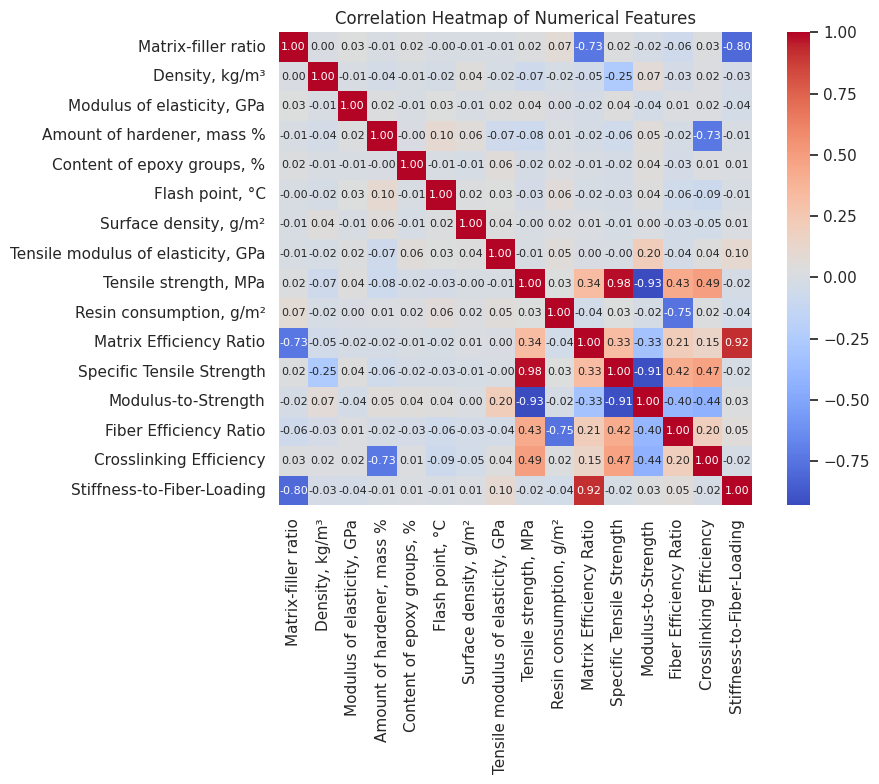

In [56]:
# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True, annot_kws={'size': 8})
plt.title("Correlation Heatmap of Numerical Features")
plt.tight_layout()
plt.show()

In [57]:
# Calculate correlation of all features with Tensile strength
corr_with_target = df.corr(numeric_only=True)['Tensile strength, MPa'].drop('Tensile strength, MPa')

# Sort by absolute correlation value for better insight
corr_sorted = corr_with_target.abs().sort_values(ascending=False).to_frame(name='Correlation with Tensile Strength')
corr_sorted['Signed Correlation'] = corr_with_target[corr_sorted.index]
corr_sorted.head(10)

,Correlation with Tensile Strength,Signed Correlation
Specific Tensile Strength,0.981955,0.981955
Modulus-to-Strength,0.930370,-0.930370
Crosslinking Efficiency,0.494031,0.494031
Fiber Efficiency Ratio,0.429211,0.429211
Matrix Efficiency Ratio,0.335710,0.335710
"Amount of hardener, mass %",0.075375,-0.075375
"Density, kg/m³",0.069981,-0.069981
"Modulus of elasticity, GPa",0.041868,0.041868
"Flash point, °C",0.031763,-0.031763
"Resin consumption, g/m²",0.028602,0.028602


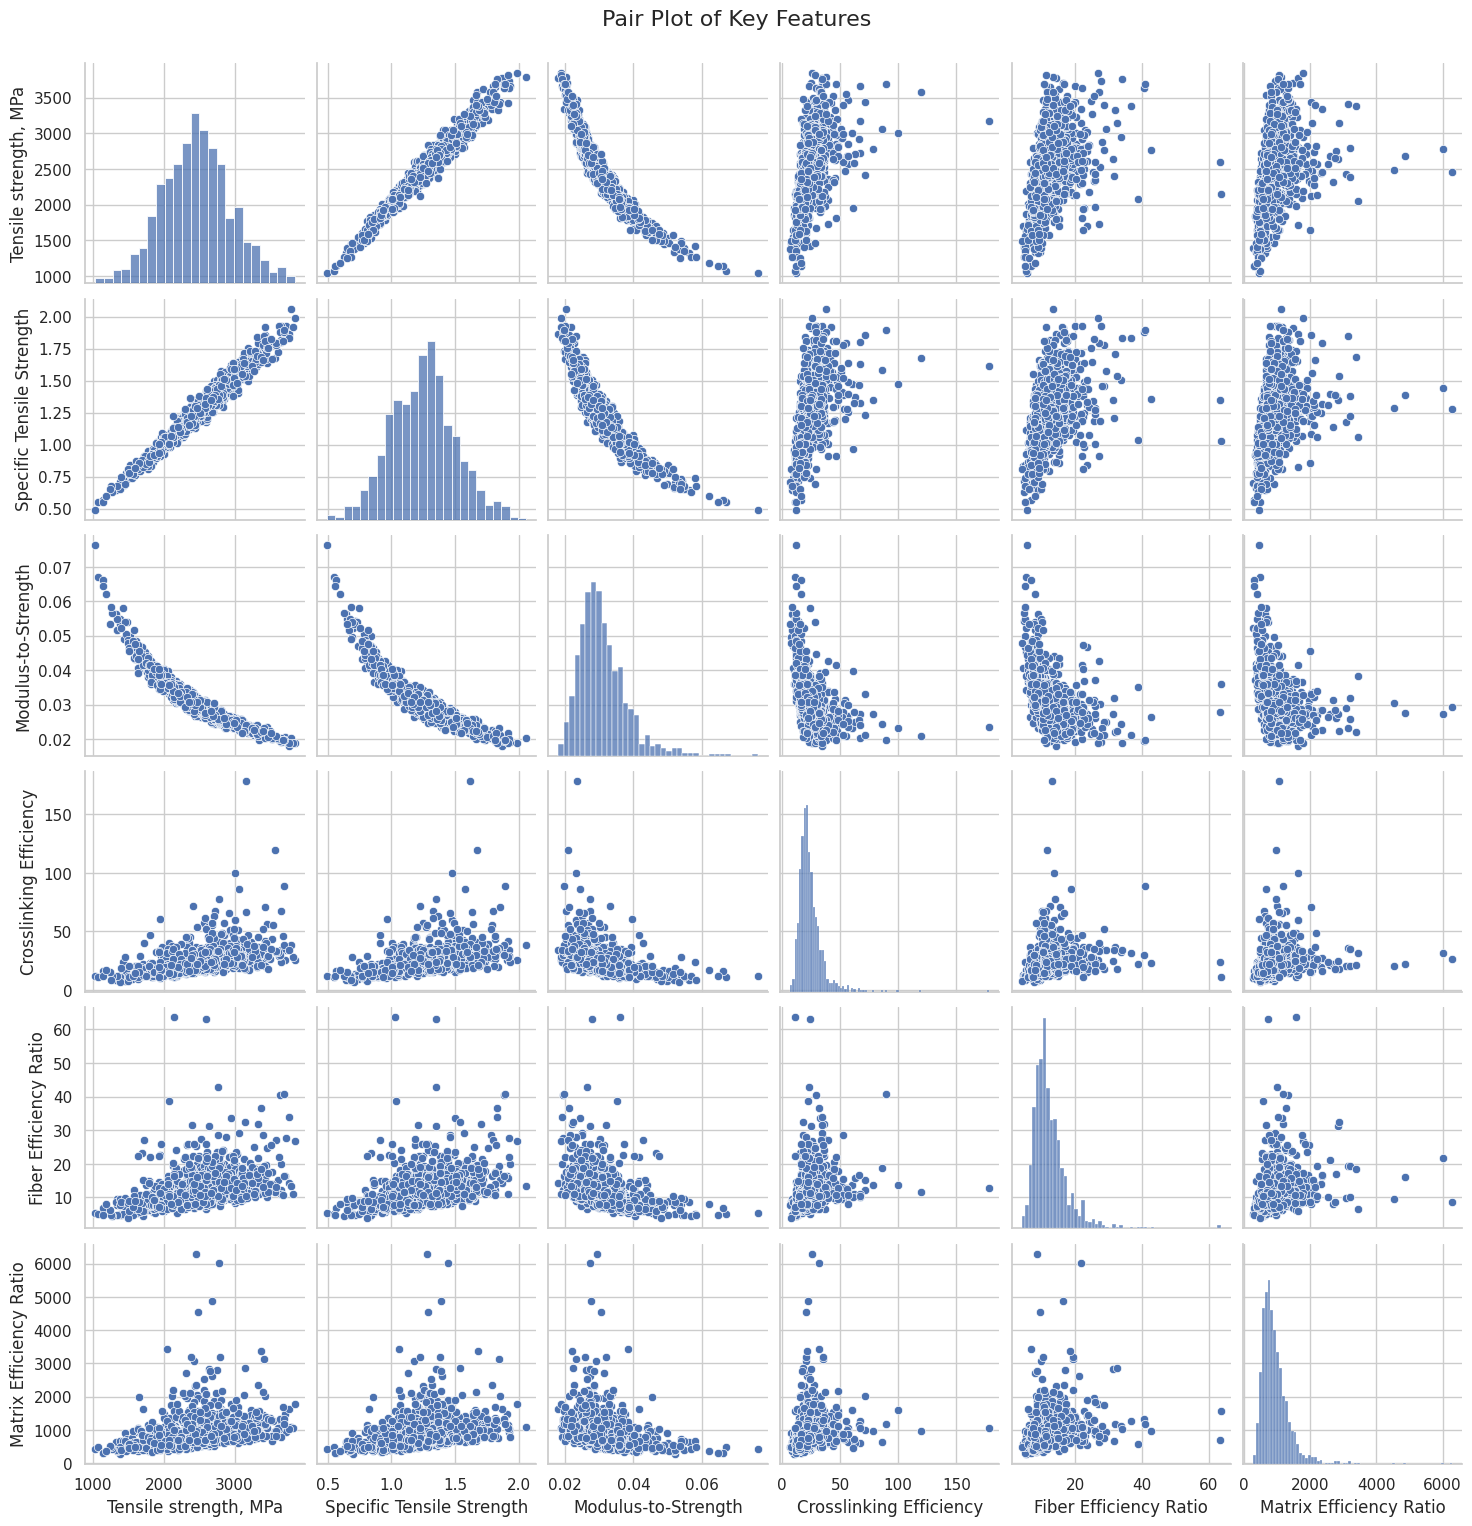

In [58]:
# 2. Pair plot (subset to avoid overcrowding)
sns.pairplot(df[['Tensile strength, MPa','Specific Tensile Strength','Modulus-to-Strength', 
                 'Crosslinking Efficiency', 'Fiber Efficiency Ratio','Matrix Efficiency Ratio']])
plt.suptitle("Pair Plot of Key Features", fontsize=16, y=1.02)
plt.show()

### 3. Data Preparation

#### Create training and test set

In [59]:
X = df.drop('Tensile strength, MPa', axis=1)
y = df['Tensile strength, MPa']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42);
X_train.head()

,Matrix-filler ratio,"Density, kg/m³","Modulus of elasticity, GPa","Amount of hardener, mass %","Content of epoxy groups, %","Flash point, °C","Surface density, g/m²","Tensile modulus of elasticity, GPa","Resin consumption, g/m²",Matrix Efficiency Ratio,Specific Tensile Strength,Modulus-to-Strength,Fiber Efficiency Ratio,Crosslinking Efficiency,Stiffness-to-Fiber-Loading
604,3.578784,1862.679792,341.672132,75.068600,25.956842,312.790306,9.046203,73.006935,160.519027,390.948033,0.751132,0.052181,8.716216,18.637867,20.399928
227,2.927797,2006.130229,950.619006,154.668800,24.180832,295.136522,710.118283,69.215144,142.512092,456.912996,0.666830,0.051740,9.386911,8.649116,23.640694
970,2.279886,1946.473054,1008.415902,151.684921,23.267756,293.317127,282.038385,72.762976,211.029671,1012.872255,1.186368,0.031510,10.942697,15.223885,31.915175
497,3.016343,2079.295010,1122.119595,105.588808,25.181815,268.548003,292.979124,70.199234,166.876118,778.139261,1.128813,0.029908,14.065135,22.229015,23.272958
919,2.030340,1960.657425,914.439785,119.615352,23.325002,227.147788,86.252875,72.951915,76.023075,968.589404,1.003013,0.037096,25.868013,16.440748,35.930885


### 4. Modeling

#### 1 - Base Model with Default Linear Regression

In [60]:
basemodel = Pipeline([
    ('scale', StandardScaler()),
    ('linreg', LinearRegression())]);
basemodel.fit(X_train, y_train);
basemodel.score(X_test, y_test);

base_y_testPred = basemodel.predict(X_test);

base_mse = mean_squared_error(y_test, base_y_testPred);
base_score = basemodel.score(X_test,y_test);
print(f"Mean Squared Error of the base model: {base_mse:.4f}")
print(f"Score of the base model: {base_score:.4f}")

Mean Squared Error of the base model: 390.0280
Score of the base model: 0.9983


#### 2 - Apply Polynomial Feature to find optimal degree

In [61]:
train_mses = []
test_mses = []
test_score = []
for i in range(1,5):
    pipe = Pipeline([
        ('scale', StandardScaler()),
        ('poly', PolynomialFeatures(degree=i, include_bias=False)),
        ('linreg', LinearRegression())
    ])
    pipe.fit(X_train, y_train);
    train_preds = pipe.predict(X_train);
    test_preds = pipe.predict(X_test);
    train_mses.append(mean_squared_error(y_train, train_preds));
    test_mses.append(mean_squared_error(y_test, test_preds));
    test_score.append(pipe.score(X_test,y_test));

best_model_complexity = test_mses.index(min(test_mses)) + 1;

The Complexity that minimized Test Error was: 2
The Best MSE of Test Error was: 1.8109731896162987e-24
The Best Score of Test Set was: 1.0


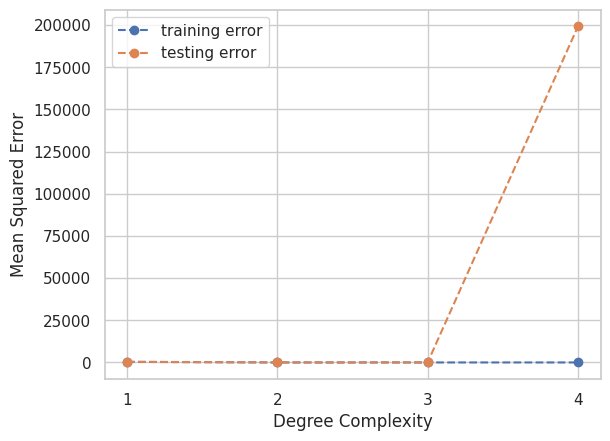

In [62]:
print(f'The Complexity that minimized Test Error was: {test_mses.index(min(test_mses)) + 1}')
print(f'The Best MSE of Test Error was: {min(test_mses)}')
print(f'The Best Score of Test Set was: {max(test_score)}')
plt.plot(range(1,5), train_mses, '--o', label = 'training error')
plt.plot(range(1,5), test_mses, '--o', label = 'testing error')
plt.xticks(range(1, 5), range(1, 5))
plt.xlabel('Degree Complexity')
plt.ylabel('Mean Squared Error')
plt.legend();

#### 3 - Ridge Regresion Model with GridSearch to find optimal alpha

In [63]:
param_dict = {'ridge__alpha': [0.0001, 0.001, 0.1, 1.0, 10.0, 100.0, 1000]}

ridgemodel = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
]);

# Create the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(estimator=ridgemodel, param_grid=param_dict, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best alpha value found by GridSearchCV
best_alpha = grid_search.best_params_['ridge__alpha']
print(f"Best alpha value: {best_alpha}")

# Get the best model (Lasso with the best alpha)
best_model = grid_search.best_estimator_

# Make predictions and Eval on the test set
y_pred = best_model.predict(X_test)
ridge_mse = mean_squared_error(y_test, y_pred)
ridge_score = best_model.score(X_test,y_test);

# Print
print(f"Mean Squared Error of the best model: {ridge_mse:.4f}")
print(f"Score of the best model: {ridge_score:.4f}")

Best alpha value: 0.0001
Mean Squared Error of the best model: 390.0285
Score of the best model: 0.9983


#### 4 - Lasso Regresion Model with GridSearch to find optimal alpha

In [64]:
# Create pipeline: Scaling + LASSO
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(max_iter=10000))
])

# Define hyperparameter grid
param_grid = {
    'lasso__alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}

# GridSearch with 5-fold CV
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

# Evaluate on test set
y_pred = grid.predict(X_test)
lasso_mse = mean_squared_error(y_test, y_pred)
best_model = grid.best_estimator_
lasso_score = best_model.score(X_test,y_test);

# Output results
print("Best alpha:", grid.best_params_['lasso__alpha'])
print(f"Mean Squared Error of the best model: {lasso_mse:.4f}")
print(f"Score of the best model: {lasso_score:.4f}")

Best alpha: 1
Mean Squared Error of the best model: 378.9543
Score of the best model: 0.9983


#### 5 - Random Forest Model + GridSearchCV

In [65]:
param_dict = {'rf__n_estimators': np.arange(50,300,50)}

rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42))
]);

# Create the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_dict, cv=5, scoring='r2')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best alpha value found by GridSearchCV
best_n = grid_search.best_params_['rf__n_estimators']
print(f"Best n_estimator value: {best_n}")

# Get the best model (Lasso with the best alpha)
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
rf_mse = mean_squared_error(y_test, y_pred)
rf_score = best_model.score(X_test,y_test);

print(f"Mean Squared Error of the best model: {rf_mse:.4f}")
print(f"Score of the best model: {rf_score:.4f}")

Best n_estimator value: 200
Mean Squared Error of the best model: 1506.8009
Score of the best model: 0.9933


#### 6 - Gradient Boosting Model + GridSearchCV

In [66]:
param_dict = {'gb__n_estimators': np.arange(50,300,50)}

gb = Pipeline([
    ('scaler', StandardScaler()),
    ('gb', GradientBoostingRegressor(random_state=42))
]);

# Create the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(estimator=gb, param_grid=param_dict, cv=5, scoring='r2')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best alpha value found by GridSearchCV
best_n = grid_search.best_params_['gb__n_estimators']
print(f"Best n_estimator value: {best_n}")

# Get the best model (Lasso with the best alpha)
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
gb_mse = mean_squared_error(y_test, y_pred)
gb_score = best_model.score(X_test,y_test);

print(f"Mean Squared Error of the best model: {gb_mse:.4f}")
print(f"Score of the best model: {gb_score:.4f}")

Best n_estimator value: 250
Mean Squared Error of the best model: 606.5007
Score of the best model: 0.9973


#### 7 - SVM Model + GridSearchCV

In [67]:
# Create pipeline
svm_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

# Define parameter grid for tuning
param_grid = {
    'svr__C': [1, 10, 100],
    'svr__gamma': ['scale', 0.01, 0.001],
    'svr__epsilon': [0.01, 0.1, 1]
}

# Perform grid search with 5-fold cross-validation
grid = GridSearchCV(svm_pipe, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_train)

# Predict on test data
y_pred = grid.predict(X_test)
best_model = grid.best_estimator_

# Evaluation
svm_mse = mean_squared_error(y_test, y_pred)
svm_score = best_model.score(X_test,y_test);

print(f"Best Parameters: {grid.best_params_}")
print(f"Mean Squared Error: {svm_mse:.4f}")
print(f"Score of the best model: {svm_score:.4f}")

Best Parameters: {'svr__C': 100, 'svr__epsilon': 0.1, 'svr__gamma': 0.01}
Mean Squared Error: 3360.6140
Score of the best model: 0.9850


#### Summary MSE of Models (Except Deep Learning)

In [68]:
# List of models to evaluate
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=0.0001),
    'Lasso': Lasso(alpha=1, max_iter=10000),
    'SVR': SVR(C=100, gamma=0.01, epsilon=0.1),
    'RandomForest': RandomForestRegressor(n_estimators=200, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=250, learning_rate=0.1, random_state=42)
}

# Record results
results = []

for name, model in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'R² Score': round(r2, 4),
        'Mean Squared Error': round(mse, 4)
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results).sort_values(by='Mean Squared Error', ascending=True)
results_df

,Model,R² Score,Mean Squared Error
2,Lasso,0.9983,378.9543
0,LinearRegression,0.9983,390.0280
1,Ridge,0.9983,390.0285
5,GradientBoosting,0.9973,606.5007
4,RandomForest,0.9933,1506.8009
3,SVR,0.9850,3360.6140


#### 8 - Deep Learning Model Keras

In [69]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=100, batch_size=16, verbose=0)

# Predict and evaluate
y_pred = model.predict(X_test_scaled)
keras_mse = mean_squared_error(y_test, y_pred)
keras_r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {keras_mse:.4f}")
print(f"R² Score: {keras_r2:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Mean Squared Error: 3818.8561
R² Score: 0.9829


### 5. Evaluation

#### Train the final model

In [70]:
# Define hyperparameter grid
param_dict = {
    'lasso__alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}

finalmodel = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('lasso', Lasso(max_iter=10000))
]);

# Create the GridSearchCV object with 5-fold cross-validation
grid = GridSearchCV(estimator=finalmodel, param_grid=param_dict, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the training data
grid.fit(X_train, y_train)

# Get the best alpha value found by GridSearchCV
best_alpha = grid.best_params_['lasso__alpha']
print(f"Best alpha value: {best_alpha}")

# Get the best model
final_model = grid.best_estimator_

# Make predictions on the test set
y_pred = final_model.predict(X_test)

# Evaluate the model
finalmodel_mse = mean_squared_error(y_test, y_pred)
finalmodel_score = final_model.score(X_test,y_test);

print(f"Mean Squared Error of the final model: {finalmodel_mse:.4f}")
print(f"Score of the final model: {finalmodel_score:.4f}")

Best alpha value: 0.1
Mean Squared Error of the final model: 0.5395
Score of the final model: 1.0000


#### Investigate the important of features

In [71]:
#Calculate the permutation importance of Test Set
results = permutation_importance(final_model, X_test, y_test);
results = pd.DataFrame(data=results.importances_mean.round(4), index=X.columns, columns=['Importance']).sort_values(by='Importance', ascending=False)
results.head(10)

,Importance
Matrix Efficiency Ratio,12.7247
Matrix-filler ratio,10.1453
Specific Tensile Strength,0.0032
"Density, kg/m³",0.0001
"Modulus of elasticity, GPa",0.0000
"Amount of hardener, mass %",-0.0000
"Content of epoxy groups, %",0.0000
"Flash point, °C",0.0000
"Surface density, g/m²",0.0000
"Tensile modulus of elasticity, GPa",0.0000


In [72]:
#Calculate the permutation importance
results = permutation_importance(final_model, X_train, y_train);
results = pd.DataFrame(data=results.importances_mean.round(4), index=X.columns, columns=['Importance']).sort_values(by='Importance', ascending=False)
results.head(10)

,Importance
Matrix Efficiency Ratio,14.0367
Matrix-filler ratio,12.5877
Specific Tensile Strength,0.0031
"Density, kg/m³",0.0001
"Modulus of elasticity, GPa",0.0000
"Amount of hardener, mass %",-0.0000
"Content of epoxy groups, %",0.0000
"Flash point, °C",0.0000
"Surface density, g/m²",0.0000
"Tensile modulus of elasticity, GPa",0.0000


### 6. Deployment


After training and evaluating the final Lasso regression model with polynomial features and hyperparameter tuning, the next step is to deploy the model for practical use. Deployment can involve several options depending on the use case:

1. **Model Serialization**:
   The trained pipeline can be saved using `joblib` or `pickle` to be reused without retraining.

   ```python
   import joblib
   joblib.dump(final_model, 'lasso_poly_model.pkl')
   ```

2. **Web/API Deployment**:

   * For interactive use, the model can be wrapped in a Flask or FastAPI application.
   * This allows users to input new data and receive predictions in real time via HTTP requests.

3. **Integration with Front-End or Dashboards**:

   * Combine the backend model with a front-end UI using Streamlit or Dash to provide a user-friendly interface.
   * Useful for business users or quality engineers in a manufacturing context.

4. **Automated Pipelines**:

   * For continuous prediction or integration into larger systems (e.g., ERP or MES), deployment into a cloud platform like AWS SageMaker, Google Vertex AI, or Azure ML may be appropriate.

5. **Validation and Monitoring**:

   * It's essential to monitor the model’s performance in production to detect drift or anomalies.
   * Retraining might be needed periodicalat or included directly into your Jupyter Notebook.


### 8. Conclusion

In this project, multiple regression techniques were explored to predict the tensile strength of composite materials based on various input features. Among the models evaluated, the Lasso regression with polynomial feature expansion and hyperparameter tuning using `GridSearchCV` provided the most interpretable and effective results.

Key findings include:

* Feature scaling and polynomial interaction terms significantly improved model performance.
* Grid search helped identify the optimal regularization parameter (`alpha`) for Lasso, balancing bias and variance.
* The final model achieved a low mean squared error and a high R² score, indicating good generalization on unseen data.
* Permutation importance analysis highlighted the most influential original features contributing to tensile strength prediction.

Overall, the results demonstrate that machine learning, particularly Lasso regression with engineered features, is a powerful tool for understanding and predicting mechanical properties in composite materials. Future work could involve exploring ensemble models, additional domain-specific features, and deploying the model into a real-time quality monitoring system.

### 7. Further Studying



* **Expand Feature Set**: Incorporate additional domain-specific features such as crosslink density, fiber orientation, curing temperature, and manufacturing process parameters to enhance model prediction accuracy.

* **Model Complexity Exploration**: Evaluate the performance of more advanced machine learning models like XGBoost, LightGBM, or stacking ensembles for better generalization.

* **Polynomial Degree Optimization**: Experiment with higher-degree polynomial transformations or feature interaction selection to capture more complex nonlinear relationships.

* **Explainable AI Tools**: Apply SHAP (SHapley Additive exPlanations) or LIME to interpret feature contributions and support materials science insights.

* **Cross-Validation Enhancements**: Use k-fold cross-validation and nested cross-validation to get more reliable estimates of model performance and to avoid overfitting during hyperparameter tuning.

* **Prediction Interval Modeling**: Explore quantile regression or Bayesian approaches to not only predict tensile strength but also estimate confidence intervals for each prediction.

* **Time-Dependent or Sequential Data**: If available, explore the use of time-series or process-sequence data to study how aging, curing time, or environmental exposure affects composite strength.

* **Deployment in Practice**: Develop a web-based tool (e.g., using Streamlit or Flask) to allow engineers or researchers to input material properties and instantly receive strength predictions.

* **Real-World Data Integration**: Incorporate industrial or in-lab datasets to test model robustness and adaptability across different composite systems ander a new markdown cell?
